<a href="https://colab.research.google.com/github/themikepeng/projecttitanicdecisiontrees/blob/main/decision_trees_project_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Decision Tree

*Copyright: © 2020 NexStream Technical Institute, LLC*  
*Author:  Michael Peng*


#Drive Setup
1.  Create a folder called `decision trees` under your `Colab Notebooks` folder
2.  Copy this reference notebook and the data files (`titanic_testing_data.csv` and `titanic_training.csv`) to the `decision trees` folder
3. Mount your Google Drive:
  
  a.  Run the cell below
  
  b.  Go to the URL given and sign into your Google account

  c.  Copy and enter the authorization code into the textbox under the cell



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [26]:
#graphviz is a nice library that will allow us to visualize our decision tree
import sys
!{sys.executable} -m pip install graphviz
from graphviz import Digraph
import os
#used in preprocessing to find the most common categorical terms and their frequencies
from collections import Counter
#NumPy: numerical and matrix tools
import numpy as np
#used in split between training and validation sets
import sklearn.model_selection
#used to import .csv data files
from numpy import genfromtxt
#conveniently performs mode (preprocessing, fit) and entropy calculations
from scipy import stats

#a very small number 
eps = 1e-5

# Intro to the Titanic dataset

**Goal: we want to implement a decision tree model that can predict whether a passenger on the Titanic survived or didn't survive**
*  The Titanic dataset is split between training data and test data
  *  The training data will then be further split into training and validation sets
  *  The test data does not contain the true class labels: we don't know if these passengers survived or not
  *  It is good practice to not predict on the test set until we've finalized our model!
*  We will then train an instance of this decision tree on the training set (sample points), and ensure that it is generalizable to the validation set
*  Finally, we will make our predictions on the test set

*  The Titanic dataset has the following fields:

1. survived: the label we want to predict; 1 indicates the person survived, whereas 0 indicates the person
died
2. pclass: Measure of socioeconomic status; 1 is upper, 2 is middle, 3 is lower
4. sex: Male/female
3. age: Fractional if less than 1
5. sibsp: Number of siblings/spouses aboard the Titanic
6. parch: Number of parents/children aboard the Titanic
7. ticket: Ticket number
8. fare: Fare
9. cabin: Cabin number
10. embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Let's start with some warmup exercises, which will go over Python concepts that are useful for our implementation:

# Warmup A: Break, Continue

In a `for` or `while` loop:
*   The `break` statement terminates the loop that contains it
*   The `continue` statement skips the rest of the code for the current iteration, and continues onto the next iteration

Note: if used in a nested loop, `break` and `continue` only affect the innermost loop!

Examples: 

In [27]:
hello = "Hello World"

print("First word:")
for c in hello:
    if c == " ":
        break
    print(c)

print("\nNo vowels:")
for c in hello:
    if c in ['a', 'e', 'i', 'o', 'u']:
        continue
    print(c)

First word:
H
e
l
l
o

No vowels:
H
l
l
 
W
r
l
d


## Try it
Using `break` and `continue`, write a function `wacky_sum` that scans an array of integers from left to right, taking a running total of elements that are **not** a multiple of 10, and stopping when encountering a negative element

In [28]:
def wacky_sum(nums):
    tot = 0
    for num in nums:
        if num < 0:
            break
        if num % 10 == 0:
            continue
        tot += num
    return tot

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=6)"
import doctest


"""
  >>> print(wacky_sum([]))
  0
  >>> print(wacky_sum([-1]))
  0
  >>> print(wacky_sum([200]))
  0
  >>> print(wacky_sum([8, 7, 7, 5, 10, 6, -8, 5]))
  33
  >>> print(wacky_sum([0, 5, 10, 15, 20, 25, 30, -35, 40, -45, 50]))
  45
  >>> print(wacky_sum([2017, 2018, 2019, -2020, 2021, -2022]))
  6054
"""
doctest.testmod()

TestResults(failed=0, attempted=6)

# Warmup B: List Comprehension
A list comprehension is a way to define a new list or 2D array based on an existing list, as a more elegant alternative to using an explicit `for` loop

A traditional `for` loop would have the format

In [29]:
'''
list2 = []
for (item) in list1:
    if (conditional):
        list2.append((operation))
return list2
'''

'\nlist2 = []\nfor (item) in list1:\n    if (conditional):\n        list2.append((operation))\nreturn list2\n'

While a list comprehension would have the format

`list2 = [(operation) for (item) in list1 if (conditional)]`

Note that the if conditional is optional!

For example, if we wanted to find the lengths of all the elements in a list that start with 'a', we could use the following list comprehension:

In [30]:
animals = ['anteater', 'quail', 'moose', 'ape', 'dolphin']
lens = [len(str) for str in animals if str[0] == 'a']
lens

[8, 3]

### Try it
Write a function `apply_evenly()` that takes in a function `func` and applies it to every other element (all even-indexed elements) in the list `list1`

In [31]:
def apply_evenly(func, list1):
    return [func(list1[i]) for i in range(0, len(list1)) if i % 2 == 0]

    #alternative solution: return [func(list1[i]) for i in range(0, len(list1), 2)]

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=5)"
import doctest

rand = [8, 5, 5, 1, 2, 3]
langs = ['Python', 'Java', 'C', 'C++', 'HTML', 'Javascript']

def lower2(str):
    return str.lower()

def sq(x):
    return x ** 2

def spread4(x):
    return (np.ones(4) * x).tolist()


"""
  >>> print(apply_evenly(len, langs))
  [6, 1, 4]
  >>> print(apply_evenly(len, animals))
  [8, 5, 7]
  >>> print(apply_evenly(lower2, langs))
  ['python', 'c', 'html']
  >>> print(apply_evenly(sq, rand))
  [64, 25, 4]
  >>> print(np.array(apply_evenly(spread4, rand)))
  [[8. 8. 8. 8.]
   [5. 5. 5. 5.]
   [2. 2. 2. 2.]]
"""
doctest.testmod()

TestResults(failed=0, attempted=5)

# Warmup C: Multidimensional Select

Suppose we have a data matrix `wellness` that contains results of a wellness survey on students, with the following feature labels (in order):
*  name
*  sleep: the hours of sleep the student got the previous night
*  meals: how many meals the student ate the previous day
*  fruit: whether the student ate any fruit the previous day (1 for "yes", 0 for "no")

Note that each row represents one student (sample point), and each column represents a feature!

We can use the row and column index to select or assign elements in a 2D Numpy ndarray (eg. a data matrix):

In [32]:
wellness = np.array([["Alice", 9, 3, 1], ["Bob", 7, 3, 0], ["Sam", 8, 3, 1], ["Tina", 6, 2, 1]])
feature_labels = ["name", "sleep", "meals", "fruit"]
print("Our ndarray: \n", wellness)

#select from row 0, column 3: 
elem = wellness[0, 3]
print("\nDid Alice have fruit yesterday?\n", elem)

#update row 2, column 1
wellness[2, 1] = 9
print("\nSam says he actually slept 9 hours yesterday: \n", wellness)

Our ndarray: 
 [['Alice' '9' '3' '1']
 ['Bob' '7' '3' '0']
 ['Sam' '8' '3' '1']
 ['Tina' '6' '2' '1']]

Did Alice have fruit yesterday?
 1

Sam says he actually slept 9 hours yesterday: 
 [['Alice' '9' '3' '1']
 ['Bob' '7' '3' '0']
 ['Sam' '9' '3' '1']
 ['Tina' '6' '2' '1']]


We can also select an entire row or column by index to get a 1D array:

In [33]:
#select row 3
row3 = wellness[3, :]
print("Tina: \n", row3)

#select column 1
col1 = wellness[:, 1]
print("sleep: \n", col1)

Tina: 
 ['Tina' '6' '2' '1']
sleep: 
 ['9' '7' '9' '6']


Using a condition in the select statement will give us a filtered 2D array:
*   Conditional format: 
`(table)[(table)[:, (column)] (comparison) (string)]`
  *  You can have multiple conditional clauses: `(table)[clause1 * clause2 + clause3 ...]`, where * is the AND operator and + is the OR operator

In [34]:
#select rows where column 1 is less than '8'
lessthan8 = wellness[wellness[:, 1] < '8']
print("Less than 8 hours of sleep: \n", lessthan8)

Less than 8 hours of sleep: 
 [['Bob' '7' '3' '0']
 ['Tina' '6' '2' '1']]


The `shape()` function of a ndarray gives us a tuple of array dimensions! Thus, for a 2D array:
*  `shape[0]` gives us the number of rows (sample points)
*  `shape[1]` gives us the number of columns (features)

In [35]:
print("Number of students:", wellness.shape[0])
print("Number of features:", wellness.shape[1])
print("\n")

#print all names
for i in range(0, wellness.shape[0]):
    print(wellness[i, 0])
print("\n")

#print all feature labels
for j in range(0, wellness.shape[1]):
    print(feature_labels[j])

Number of students: 4
Number of features: 4


Alice
Bob
Sam
Tina


name
sleep
meals
fruit


### Try it
Use a select statement to find the names of all the students who had at least 3 meals yesterday

In [36]:
names = ...
names = wellness[wellness[:, 2] >= '3'][:, 0]

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=1)"
import doctest
"""
  >>> print(names)
  ['Alice' 'Bob' 'Sam']
"""
doctest.testmod()

TestResults(failed=0, attempted=1)

# Warmup D: Information Gain Calculation

Recall the equations for calculating information gain:

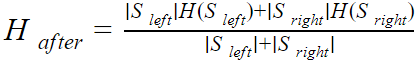

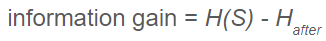

Where:
*  S<sub>left</sub> is the set of class labels belonging to the left child post-split, represented by `left` below
*  S<sub>right</sub> is the set of class labels belonging to the right child post-split, represented by `right` below
*  S is the set of all class labels belonging to the current node, represented by `y` below
*  |s| is the number of elements in **any** set of class labels s— for our purposes, find |s| using the `.size` attribute of `numpy.ndarray` (the three sets mentioned above will be represented by ndarrays)
*  H(s) is the entropy of **any** set of class labels s— which, for now, will be found by calling the function `entropy0` on s
*  The `-, +, *, /` operators are also useful, as are parenthesis for order of operation

Fill in the information gain calculation within `igcalc()` by combining the two equations above; this calculation will be used later in our `DecisionTree` implementation:

In [37]:
#This is actually the gini impurity function, which has similar behavior to 
#the entropy function, and is sometimes used in place of entropy in decision
#trees; however, we will soon implement the actual entropy function
def entropy0(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    eq = 0
    for cnt in counts:
        p_i = cnt / labels.size
        eq += p_i * (1 - p_i)
    return eq

def igcalc (left, right, y):
    calc = ...
    calc = entropy0(y) - (left.size * entropy0(left) + right.size * entropy0(right)) / (left.size + right.size)
    return calc

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=6)"
import doctest

left1, right1, y1 = np.array([0, 1]), np.array([0, 1]), np.array([0, 1, 0, 1])
left2, right2, y2 = np.array([0, 0]), np.array([1, 1]), np.array([0, 1, 0, 1])

left3, right3, y3 = np.array([0, 0, 1, 0]), np.array([1, 1, 1, 2]), np.array([0, 0, 1, 0, 1, 1, 1, 2])
left4, right4, y4 = np.array([0, 0, 2]), np.array([1, 0, 1, 1, 1]), np.array([0, 0, 1, 0, 1, 1, 1, 2])

left5, right5, y5 = np.array([0, 0, 0]), np.array([1, 1, 1, 1, 2]), np.array([0, 0, 1, 0, 1, 1, 1, 2])
left6, right6, y6 = np.array([0, 0, 0, 2]), np.array([1, 1, 1, 1]), np.array([0, 0, 1, 0, 1, 1, 1, 2])

"""
  >>> print(igcalc(left1, right1, y1))
  0.0
  >>> print(igcalc(left2, right2, y2))
  0.5
  >>> print(igcalc(left3, right3, y3))
  0.21875
  >>> print(igcalc(left4, right4, y4))
  0.2270833333333333
  >>> print(igcalc(left5, right5, y5))
  0.39375
  >>> print(igcalc(left6, right6, y6))
  0.40625
"""
doctest.testmod()

TestResults(failed=0, attempted=6)

# Helpful Functions
We are now ready to implement our `DecisionTree` class! Each section below will walk through the implementation of a function or method, making references to the following simple NumPy and SciPy functions as needed:
*   ndarray transpose https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html
*ndarray shape https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html
*   numpy hstack https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
*   numpy unique https://numpy.org/doc/stable/reference/generated/numpy.unique.html
*   numpy where https://numpy.org/doc/stable/reference/generated/numpy.where.html
*numpy linspace https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
*numpy nan_to_num https://numpy.org/doc/stable/reference/generated/numpy.nan_to_num.html
*numpy ones, zeros https://numpy.org/doc/stable/reference/generated/numpy.ones.html https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
*  numpy unravel_index https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html
*   collections.Counter and most_common() https://docs.python.org/2/library/collections.html
*   scipy.stats.mode https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html
  *   scipy ModeResult https://www.kite.com/python/docs/scipy.stats.mstats_basic.ModeResult
*   scipy.stats.entropy https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html


# Part A: preprocessing
A function to preprocess our data matrix into something our decision tree can use

Parameters:
*   `data` is a numpy ndarray: the **full** data matrix with sample points as rows, and predictive features (fields 2 through 10) as columns
*   `fill_mode` is a boolean (default True) for whether we want to fill in each missing value with the mode of its column
  *  **Here, we are inferring the missing values of a column based on other values of the column; we use the mode of non-missing values because it works for both quantitative and categorical variables**
*   `min_freq` is an integer (default 10): threshold for the minimum number of times a category must appear before we'd want to one-hot encode it into a binary variable
*   `onehot_cols` is an array with the indeces of all the categorical variables in `data` to one-hot encode

Fill in the `preprocess()` function as described:


1.   Assign missing values (look for values that are `b''`) in the `data` table to `b'-1'` temporarily
2.   Declare `onehot_encoding` and `onehot_features` to be empty arrays
3.   Iterate through every `col` in `onehot_cols`

  a. Pull column `col` from `data` (recall that `onehot_cols` is an array of column indices), and use it to intialize a `Counter()` called `counter`

  b. Iterate through every `term` (`(category, count)` pair), in descending order by count (hint: check the `most_common()` method of `counter`)

  *   Check if the `term`'s category represents a missing value (hint: what did you replace missing values with earlier?) if so, continue to next iteration
  *   Check if the `term`'s count is below our threshold; if so, break the loop
  *   Append `term`'s category to `onehot_features`, and a binary array to `onehot_encoding`, as described in the one-hot encoding process (hint: check `data`'s `col`-th column to get a boolean array, then cast it as an array of floats to get a binary array)

  c. set `data`'s `col`-th column to `'0'` as it won't be used anymore
4.   Convert `onehot_encoding` to a numpy array and transpose it; our binary arrays are now binary columns
5.   Cast `data` as a numpy array of floats, then combine its columns with those of `onehot_encoding` (hint: check the `hstack()` function of numpy)
6.   Check if `fill_mode` is enabled; if so, iterate through every column index `i` of `data`
  
  a.   Find the mode of column `i` for all non-missing values of the column; use the condition `(data[:, i] < -1 - eps) + (data[:, i] > -1 + eps)` to select rows of `data` where column `i` is **not** missing, then extract column `i` from the resulting table (hint: use `stats.mode()` from scipy, extract the mode from the ModeResult that it returns, and take element 0)
  
  b.   Assign the mode to **missing** values of column `i`; use a similar process as above to select missing values, but use the condition `(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)` instead
7.   return `data, onehot_features`


# Part B: DecisionTree constructor

Creates a decision tree node

Parameters:
*   `max_depth` is an int (default 3) for how many levels of decision nodes we want in our current `DecisionTree` (a leaf would have `max_depth` 0)
*   `feature_labels` is an array of strings (default None) for the names of our features

Initialize the following based on the arguments passed in:
*   `self.max_depth`
*   `self.features`

Initialize the following as an empty decision tree node:
*   `self.left, self.right`
*   `self.split_idx, self.thresh`
*   `self.data, self.labels, self.pred`

Note that the first four will be assigned in decision nodes, while the last three will be assigned in leaf nodes



# Part C: entropy
Calculates the entropy from a set of class labels

Parameters:
*   `labels` is a list of class labels (corresponding to points)
*   `base` is an int (default None): the base to be used for the log function within entropy (None corresponds to natural log in `stats.entropy()`)

Fill in the `entropy1()` function as described:
1.   Get the counts for each class in `labels` (hint: check the `unique()` function of numpy)
2.   Return the entropy calculated on the counts; you may use `stats.entropy() ` from scipy

# Part D: information gain
Calculates the information gain from splitting points on feature column `X` and value `thresh`

Parameters:
*   `X` is an array of numeric values: the column of our data matrix that corresponds to the feature that we want to try splitting on
*   `y` is an array of class labels (corresponding to points in data matrix)
*   `thresh` is a numeric value: the value that we want to try splitting on

Fill in the `information_gain()` function as described:
1.   Find the two lists of **class labels** for the left and right children after the split, and create numpy arrays from these lists (hint: use list comprehensions with conditions `X[i] < thresh`, `X[i] >= thresh` as conditions)
2.   Calculate the information gain from the left and right class labels like in **the warmup**, but with `entropy1()` in place of `entropy0()`
3.   Return the information gain

# Part E: split test
Given a feature and split value, splits sample points and sample point indices in two

Parameters:

*   `X` is a numpy ndarray: the data matrix with sample points in the current node as rows, and predictive features (fields 2 through 10) as columns
*   `idx` is an int: the column index of the feature that we want to split on
*   `thresh` is a numeric value: the value that we want to split on

Fill in the `split_test()` function as described:
1.   Define `idx0`, `idx1` to be sets of sample point indices (rows in `X`) for the left and right children: ie. one where the values of feature `idx` are less than `thresh`, and another where they are greater than or equal to `thresh` (hint: check the `where()` function of numpy; provide a condition only and get the 0-th element of the function call)
2.   Using the two sets of indices above, split `X` into two ndarrays `X0`, `X1`: one for the left child, and one for the right child
3.   Return `X0`, `idx0`, `X1`, `idx1` in that order



# Part F: split
Splits a set of data points **and** a set of class labels in two, given a feature and split value

Parameters:
*   `X` is a numpy ndarray: the data matrix with sample points in the current node as rows, and predictive features (fields 2 through 10) as columns
*   `y` is a list of class labels (corresponding to points)
*   `idx` is an int: the column index of the feature that we want to split on
*   `thresh` is a numeric value: the value that we want to split on

Fill in the `split()` function as described:
1.   Call `split_test()` to get `X0`, `idx0`, `X1`, `idx1` as described in the previous part
2.   Use `idx0`, `idx1` to split `y` into two lists `y0` and `y1`
3.   Return `X0`, `y0`, `X1`, `y1` in that order

# Part G: fit
Recursively grows a decision tree given a set of data points and a set of class labels

Parameters:
*   `X` is a numpy ndarray: the data matrix with sample points in the current node as rows, and predictive features (fields 2 through 10) as columns
*   `y` is a list of class labels (corresponding to points)

Fill in the `fit()` function as described:

1.   Check if the `self.max_depth` of the tree is greater than 0

Fill in the following under the main `if` clause
2.   Create an empty array `gains` to store calculated information gains
3.   Use list comprehension to create a 2D array: for each feature index `j`, use linear interpolation with `num=10` to find a 1D array of split values we'd like to try for that feature (hint #1: you can use `linspace()` in numpy to create the 1D array) (hint #2: use `X.shape[1]` to get the total number of features) 

*   Linear interpolation in this case: Take the minimum and maximum sample values of column `j`, x<sub>j-min</sub> and x<sub>j-max</sub>, and try `num` evenly spaced numbers over the interval [x<sub>j-min</sub> + eps, x<sub>j-max</sub> - eps] where eps is a very small number (hint #1: use `np.min()` and `np.max()`) (hint #2: `eps` is already defined)
*   Finally, create a numpy array from the 2D array and assign it to `thresh_list`
4.  For each feature index `j`:

  a.  Use list comprehension to create a 1D array: for each value `t` in row `j` of `thresh_list`, call `information_gain()` on column `j` of `X`, `y`, and `t`

  b.  Append the 1D array to `gains`
5.  Convert `gains` to a numpy array, and call `np.nan_to_num()` on `gains` to replace NaN values with 0.0
6.  Find the feature index and index of the threshold value that corresponds to the maximum information gain in `gains`, and assign them to `self.split_idx, thresh_idx`
*   `gains` is a 2D array, but `np.argmax()` returns the 1D coordinate of the maximum gain along a **flattened** array! We need the 2D coordinates from `gain`, which can be found using `np.unravel_index(np.argmax(gains), gains.shape)`
7.  Use `self.split_idx, thresh_idx` to find the threshold value in `thresh_list` that corresponds to the maximum gain; assign the value to `self.thresh` (hint: `thresh_list` is indexed the same way as `gains`)
8.  Call `split()` to split our data point set and class label set in two: `X0, y0, X1, y1`
9.  Using an `if` statement to check that both `X0` and `X1` are not empty: (this will dictate that the current node be a decision node)

  a.  Construct two `DecisionTrees`, one for the left and one for the right child, and assign them to `self.left` and `self.right` (hint: what should you pass into the constructor for `max_depth` and `feature_labels`? How deep do you want a child to be in relation to `self.max_depth`?)

  b.  Make a recursive call to `fit()`, for both `self.left` and `self.right`, passing in their respective data point sets and class label sets
10.  Under `else`: (this will dictate a leaf node since either `X0`or `X1` is empty; we cannot split further)

  a.  Set `self.max_depth` to 0

  b.  Store `X, y` in `self.data, self.labels`

  c.  Assign `self.pred`, the final prediction of the node, to the mode of `y` (hint: use `stats.mode()` from scipy, extract the mode from the ModeResult that it returns, and take element 0)

Fill in the following under the main `else` clause (this will dictate a leaf node since we have reached the max depth)
11.  As above, store `X, y` in `self.data, self.labels`, then assign `self.pred`, the final prediction of the node, to be the mode of `y`

Finally, outside of the `if-else` statements, return the current node `self`

# Part H: predict
Recursively traverses a decision tree to predict class labels for a given set of data points

Parameters:
*   `X` is a numpy ndarray: the data matrix with sample points in the current node as rows, and predictive features (fields 2 through 10) as columns

Fill in the `predict()` function as described:
1.  Check if `self` is a leaf node (what would `max_depth` be?)
  
  a.  Return a 1D numpy array predicting `self.pred` for each sample point (hint #1: use the `*` operator to broadcast `self.pred` onto an array of ones the size of n, where n is the number of sample points) (hint #2: check `ones()` of numpy)
2.  Else

  a.  Call `split_test()` to split our data point set and index set in two: `X0, idx0, X1, idx1`

  b.  Define `yhat` to be a 1D numpy array with a zero for each sample point (hint: check `zeros()` of numpy)

  c.  Assign the values of `yhat` indexed by `idx0`, by recursively predicting on `X0` using the left child node
  
  d.  Repeat for `idx1` and `X1` using the right child node

  e.  Return the node's predictions `yhat`



In [38]:
class DecisionTree:
    #Part B: Creates a decision tree node
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        # for non-leaf nodes
        self.left, self.right = None, None
        # for non-leaf nodes
        self.split_idx, self.thresh = None, None
        # for leaf nodes
        self.data, self.labels, self.pred = None, None, None

    #Part C: Calculates the entropy from a set of class labels
    global entropy1
    def entropy1(labels, base=None):
        #get counts for each class label in labels; find and return entropy
        value,counts = np.unique(labels, return_counts=True)
        return stats.entropy(counts, base=base)
    
    @staticmethod
    #Part D: Calculates the information gain from splitting points on feature column X and value thresh
    def information_gain(X, y, thresh):
        #condition X against thresh to split y into left and right child sets
        left = np.array([y[i] for i in range(0, y.size) if X[i] < thresh])
        right = np.array([y[i] for i in range(0, y.size) if X[i] >= thresh])
        #calculate and return information gain from equation
        gain = entropy1(y) - (left.size * entropy1(left) + right.size * entropy1(right)) / (left.size + right.size)
        return gain

    #Part F: Splits a set of data points and a set of class labels in two, given a feature and split value
    def split(self, X, y, idx, thresh):
        #call split_test, then use the two sets of indices to split y into two sets
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        #return X0, y0, X1, y1
        return X0, y0, X1, y1

    #Part E: Given a feature and split value, splits sample points and sample point indices in two
    def split_test(self, X, idx, thresh):
        #get two sets of sample point indices by conditioning column idx of X against thresh
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        #split X into two sets using the sample point indices above
        #return X0, idx0, X1, idx1
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    #Part G: Recursively grows a decision tree given a set of data points and a set of class labels
    def fit(self, X, y):
        #check self.max_depth
        if self.max_depth > 0:
            #create gains array
            gains = []
            #build thresh_list: values to try for each feature thresholding with a linear interpolation of 10 values; 
            #including logic to prevent thresholding on exactly the minimum or maximum values
            #which may not lead to any meaningful node splits
            thresh_list = np.array([
                np.linspace(np.min(X[:, j]) + eps, np.max(X[:, j]) - eps, num=10)
                for j in range(X.shape[1])
            ])
            #compute info gain for all single-dimension splits; convert to np array and remove NaNs
            for j in range(X.shape[1]):
                gains.append([self.information_gain(X[:, j], y, t) for t in thresh_list[j, :]])
            gains = np.nan_to_num(np.array(gains))
            #find optimal feature index and index of threshold value using argmax and unravel_index
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            #extract the optimal threshold value from thresh_list
            self.thresh = thresh_list[self.split_idx, thresh_idx]
            #call split() to get two sets of data pts and class labels
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            #check that neither X0 and X1 are empty (decision node): recursively build and fit left/right children
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            #else (leaf node): set max_depth to 0, store X and y, and assign mode of y to be the final pred
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        #else (leaf node): max_depth is 0, store X and y, and assign mode of y to be the final pred
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        #return current node
        return self

    #Part H: Recursively traverses a decision tree to predict class labels for a given set of data points
    def predict(self, X):
        #check if leaf node: return pred for all sample pts
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        #else (decision node): call split_test() to split into two sets of sample pts and sample pt indices;
        #create yhat = array of 0's;
        #recursively predict on the two sets using the left and right children and insert into yhat
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            #return all predictions
            return yhat
        
#Part A: A function to preprocess our data matrix into something our decision tree can use
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # Temporarily assign -1 to missing data
    data[data == b''] = b'-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        #initialize a Counter from data column, to find the most common categorical terms and their frequencies
        counter = Counter(data[:, col])
        for term in counter.most_common():
            #ignore missing terms and only encode category if frequency is above threshold
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            #keep track of feature-column correspondence, then one-hot encode into binary arrays
            #neutralize original column
            #transpose to get binary columns and add them to data matrix
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            #get values of column i that are not close to -1
            #get the mode of the above using scipy.stats.mode and accessing ModeResult
            #assign mode to values of column i that are close to -1
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode
    #return data, onehot_features
    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)

# Preprocessing
After implementing all the decision tree functions, run the cell below to preprocess our Titanic training and test data:

In [39]:
#import titanic dataset files as training and test data
path_train = '/content/drive/My Drive/Colab Notebooks/decision trees/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)

path_test = '/content/drive/My Drive/Colab Notebooks/decision trees/titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)

#define our set of class labels from imported test data (0 = Died, 1 = Survived)
y_titanic = data[1:, 0]
class_names_titanic = ["Died", "Survived"]

#for class labels AND preprocessed data, use labeled_idx to keep only rows where class labels are present
labeled_idx = np.where(y_titanic != b'')[0]
y_titanic = np.array(y_titanic[labeled_idx], dtype=np.int)

#preprocess training data and test data
print("Preprocessing the titanic dataset")
X_titanic, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
X_titanic = X_titanic[labeled_idx, :]
Z_titanic, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])

#check that our two sets have same # of columns
#define list of feature names
assert X_titanic.shape[1] == Z_titanic.shape[1]
features_titanic = list(data[0, 1:]) + onehot_features

Preprocessing the titanic dataset


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


# Before using our `DecisionTree`:


*   Split our training data into training and validation sets
  *  Randomly assign 20% of data to validation set, keeping 80% in training set; this is commonly called the "80/20" split
*  Print the names of our features, before and after the preprocessing of our data matrices
  *  Recall that we one-hot encoded while preprocessing!
*  Run a "dummy" constant classifier on training set, which predicts 0 ("didn't survive") for each passenger
  *  We'll refer back to this as a baseline accuracy



In [40]:
#split training into 80% training, 20% validation; use random state to keep it deterministic for our purposes
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=49)

#print train, test, train/val sizes
print("Total training size:", X_titanic.shape[0])
print("Total test size:", Z_titanic.shape[0])
print("Training/validation sizes:", X_train.shape[0], X_val.shape[0])

#print our feature labels before and after one-hot encoding
print("\n\nFeatures before one-hot encoding:", list(data[0, 1:]))
print("Features after one-hot encoding:", features_titanic)

#constant classifier which always predicts 0
print("\n\nAccuracy of constant classifier:", 1 - np.sum(y_titanic) / y_titanic.size)

Total training size: 999
Total test size: 310
Training/validation sizes: 799 200


Features before one-hot encoding: [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked']
Features after one-hot encoding: [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']


Accuracy of constant classifier: 0.6136136136136137


# Training our `DecisionTree`
We're finally ready to apply our `DecisionTree` to the training set! Run the cell below to:


*   Create an instance of `DecisionTree` and grow it on our set of training points
*  Use the `DecisionTree` to predict on the training and validation sets, and obtain the training and validation accuracies
  *  The training accuracy is how well our decision tree is able to model the dataset that it was constructed on
  *  The validation accuracy is how well it can generalize to predict on data that it hasn't seen yet
*  Check that training and validation accuracies match the staff accuracies (which should be the case if `DecisionTree` was implemented as described)



In [41]:
#create a DecisionTree instance and train it on the training set
dt = DecisionTree(max_depth=8, feature_labels=features_titanic)
dt.fit(X_train, y_train)

#use it to predict on our training set and validation set
train_pred = dt.predict(X_train)
val_pred = dt.predict(X_val)
train_acc = 1 - np.count_nonzero(train_pred - y_train) / y_train.size
val_acc = 1 - np.count_nonzero(val_pred - y_val) / y_val.size
print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=2)"
import doctest
"""
  >>> print(train_acc)
  0.8660826032540676
  >>> print(val_acc)
  0.795
"""
doctest.testmod()

Training Accuracy: 0.8660826032540676
Validation Accuracy: 0.795


TestResults(failed=0, attempted=2)

# Final Predictions
Once we are satisfied with our validation accuracy, we can make our final predictions on the test set

*   Now that validation is complete, we should train on our **entire** training set (including points previously assigned to validation) before making test predictions
*   Predict on the test set, and ensure that the test predictions match the staff predictions
  *  Recall that we don't have the true class labels for the test set, so we cannot obtain a test accuracy! However, a test accuracy would be used in practice as a final evaluation of the model's performance



In [42]:
#train on entire training set
dt.fit(X_titanic, y_titanic)
test_pred = dt.predict(Z_titanic)

#-------------------------------------------------------------------------------------------------
#Test with the following doctest test vectors.
#DO NOT EDIT THE TEST CODE!!!!
#Even changing the spacing can cause errors.
#The test code will automatically execute when you run the cell.
#You should test all your combination of outputs but your code at least must pass these exact tests.
#If your code fails, you will see a description in the console cell.
#If your code passes, you will see the message: "TestResults(failed=0, attempted=1)"
import doctest
"""
  >>> print(test_pred)
  [1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
   0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
   1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
   1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
   1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
   0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
   0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
   0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
   1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
"""
doctest.testmod()

TestResults(failed=0, attempted=1)

# Bonus: Visualization

*  Recall that we imported the `graphviz` module, which is a Python interface for the popular Graphviz graph visualization software
*  In particular, we will be using the Digraph (directed graph) class from the module to represent a decision tree

Run the following code to visualize the decision tree trained above— but limited to depth 3, for visibility

*   The PDF file will show up in `/Colab Notebooks/decision trees/test-output/`
*  It should look like: ![](https://drive.google.com/uc?export=view&id=1PE9UNo-df4d7KGacACFaiKOLWT9hOGBK)
*  Each decision node shows the name of the feature (corresponding to `self.split_idx`), and the threshold value the feature is split on `self.thresh`
  *  For example, in the decision node labeled "b'fare', threshold 27.816...", we are splitting on the "fare" feature using a threshold value ~27.816; this means that when predicting on a sample point, we will look at this node's left child if the point's "fare" is less than 27.816, or right child if the point's "fare" is greater than (or equal to) 27.816
*  Each leaf node shows its final prediction `self.pred`
  *  For example, in the far left leaf node labeled "class: 1", we will predict class 1 (survived) for any sample point that lands on this node



In [43]:
tree_vis = Digraph(comment='Titanic decision tree')
i = 0

#recursive function that walks through a tree and builds the Digraph node by node (either threshold or class label)
def walk(DT):
    global i
    #leaf node
    if DT.max_depth == 0:
        #nodenum = unique label for every node
        nodenum = str(i)
        tree_vis.node(nodenum, 'class: ' + str(DT.pred))
        i += 1
        return nodenum
    #decision node; recursive calls
    else:
        #print feature to split on, and threshold
        label = str(DT.features[DT.split_idx]) + ', threshold ' + str(DT.thresh)
        nodenum = str(i)
        i += 1
        tree_vis.node(nodenum, label)
        tree_vis.edge(nodenum, walk(DT.left))
        tree_vis.edge(nodenum, walk(DT.right))
        return nodenum

#create and train the depth 3 DecisionTree
dt3 = DecisionTree(max_depth=3, feature_labels=features_titanic)
dt3.fit(X_train, y_train)

walk(dt3)
#un-comment to print the link between nodes
#print(tree_vis.source)

#delete existing output graph if exists
#render graph
try:
    os.remove('test-output/titanic_3.gv')
except OSError:
    pass

tree_vis.render('/content/drive/My Drive/Colab Notebooks/decision trees/test-output/titanic_3.gv', view=True)

'/content/drive/My Drive/Colab Notebooks/decision trees/test-output/titanic_3.gv.pdf'